In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract  # 글자 인식(사진에서 번호판 숫자 추출)
plt.style.use('dark_background')

175 483 3


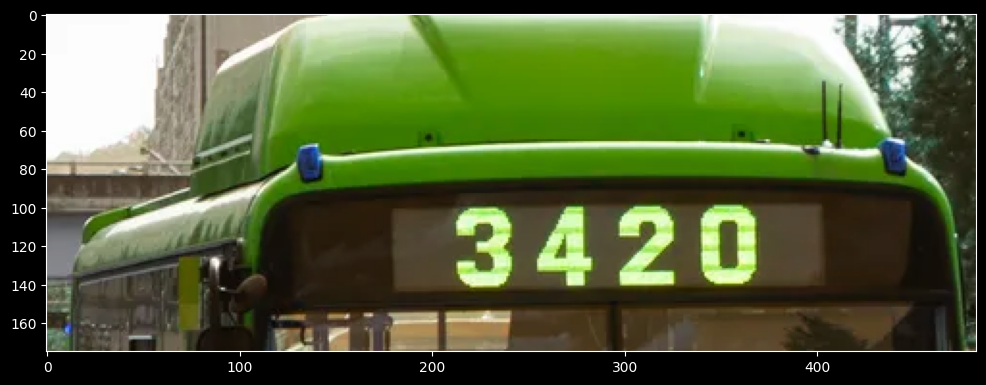

In [2]:
img_ori = cv2.imread('numbus.png')

height, width, channel = img_ori.shape

plt.figure(figsize=(12, 10))
plt.imshow(img_ori,cmap='gray')
print(height, width, channel)

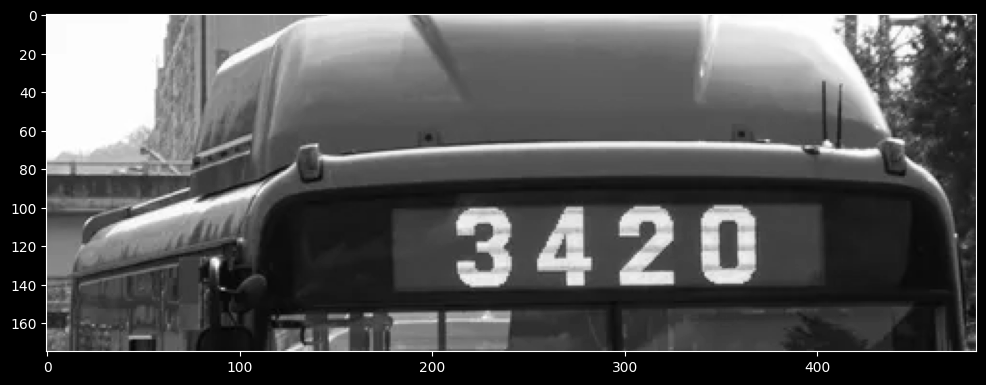

In [3]:
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(12,10))
plt.imshow(gray, cmap='gray')

In [4]:
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

img_blur_thresh = cv2.adaptiveThreshold(
    img_blurred,
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=19,
    C=9
)

In [5]:
img_thresh = cv2.adaptiveThreshold(
    gray,
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=19,
    C=9
)

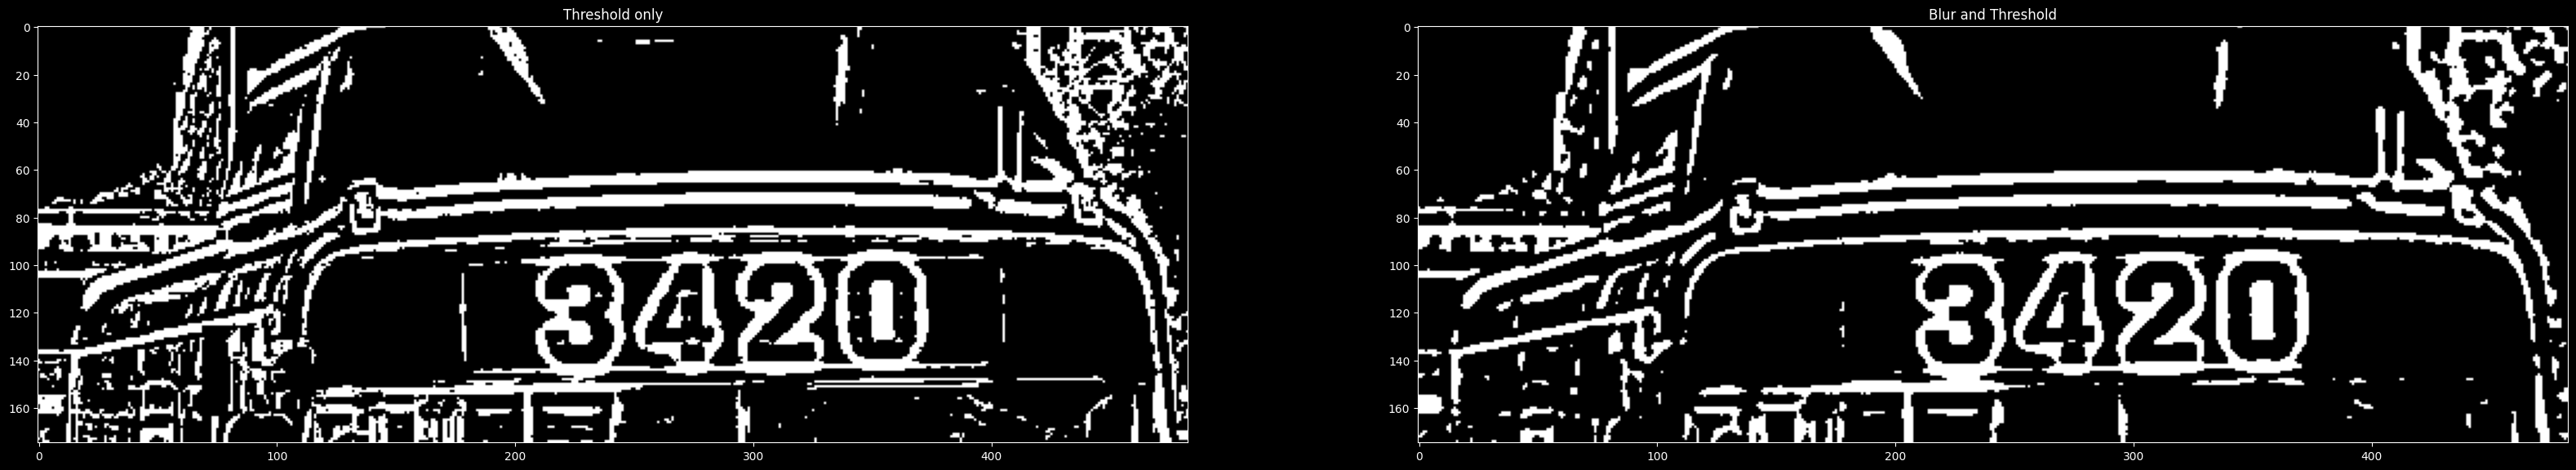

In [6]:
plt.figure(figsize=(40,40))
plt.subplot(1,2,1)
plt.title('Threshold only')
plt.imshow(img_thresh, cmap='gray')
plt.subplot(1,2,2)
plt.title('Blur and Threshold')
plt.imshow(img_blur_thresh, cmap='gray')

Text(0.5, 1.0, 'Blur and Threshold')

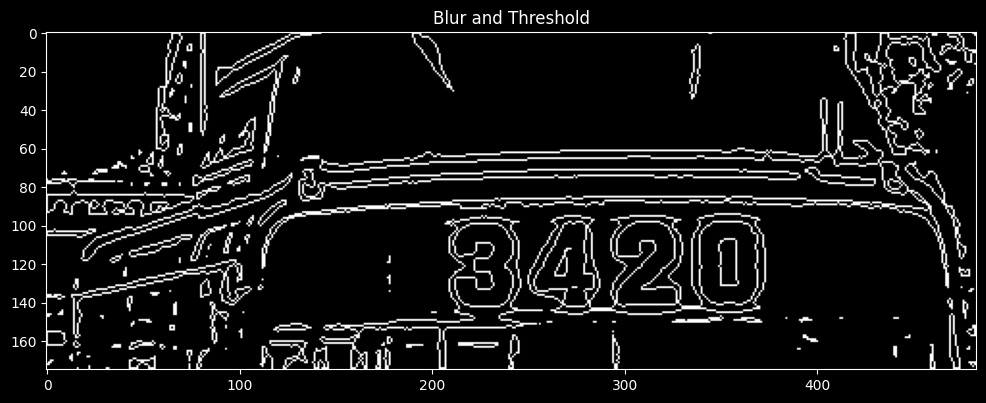

In [7]:
contours, _ = cv2.findContours(
    img_blur_thresh,
    mode=cv2.RETR_LIST,
    method=cv2.CHAIN_APPROX_SIMPLE
)
contours2, _ = cv2.findContours(
    img_blur_thresh,
    mode=cv2.RETR_LIST,
    method=cv2.CHAIN_APPROX_SIMPLE
)
temp_result = np.zeros((height, width, channel), dtype=np.uint8)
cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255,255,255))

plt.figure(figsize=(12, 40))
plt.imshow(temp_result)
plt.title('Blur and Threshold')


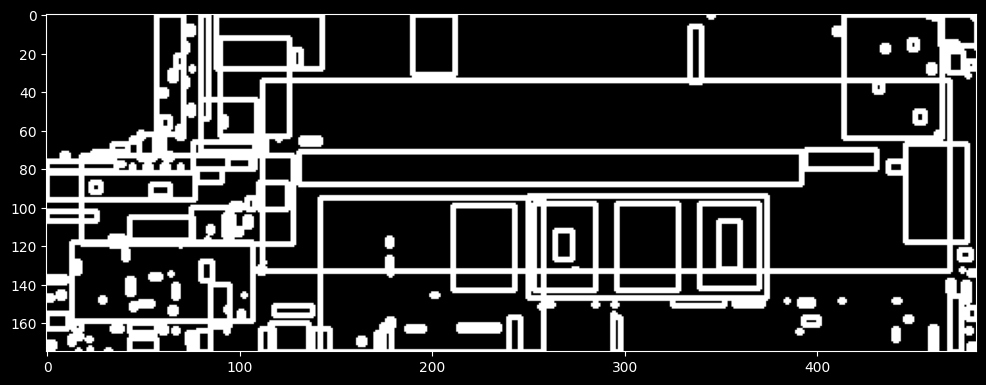

In [8]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x,y), pt2=(x+w, y+h), color=(255,255,255), thickness=2)
    
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })
    
plt.figure(figsize=(12,10))
plt.imshow(temp_result, cmap='gray')

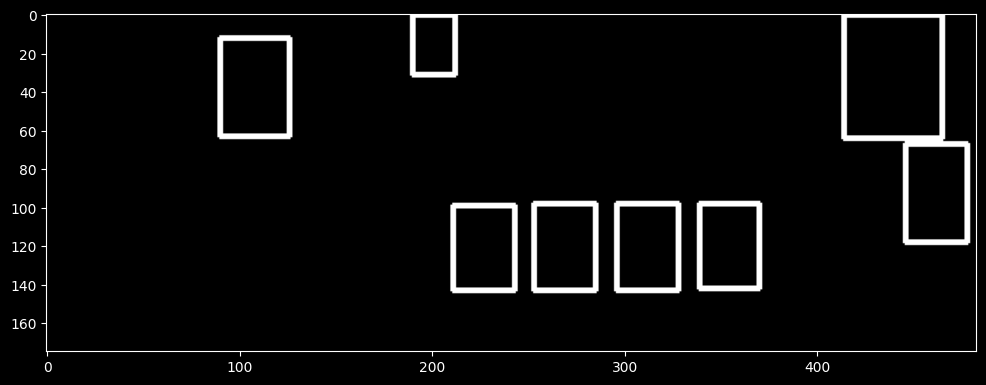

In [9]:
MIN_AREA = 200 # 영역의 최소 면적
MIN_WIDTH, MIN_HEIGHT= 10, 20 # 최소 높이 최소 너비
MIN_RATIO, MAX_RATIO = 0.5, 1 # 너비/높이 의 비율 범위
possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)

temp_result = np.zeros((height, width, channel), dtype = np.uint8) # np.uint8 8비트 양수 0~255

for d in possible_contours:
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)
plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

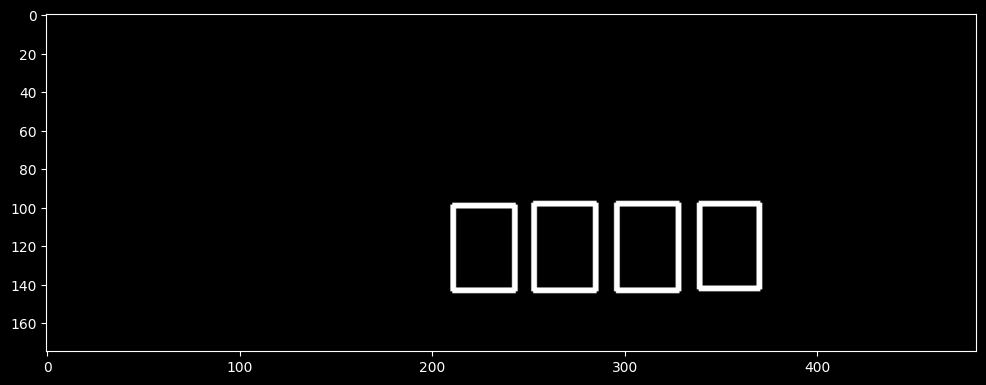

In [10]:
MAX_DIAG_MULTIPLYER = 5
MAX_ANGLE_DIFF = 12.0
MAX_AREA_DIFF = 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 3

def find_chars(contour_list):
    matched_result_idx = []
    
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue
                
            dx = abs(d1['cx'] - d2['cx']) # contour 영역의 중심좌표 차
            dy = abs(d1['cy'] - d2['cy'])
            
            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)//2
            
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']
            
            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])
                
        matched_contours_idx.append(d1['idx'])
        
        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue
            
        matched_result_idx.append(matched_contours_idx)
        
        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])
        
        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)
            
        break
        
    return matched_result_idx

result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))
    
temp_result = np.zeros((height, width, channel), dtype=np.uint8)
box_x1,box_y1=width,height
box_x2,box_y2=0,0
for r in matched_result:
    for d in r:
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255,255,255), thickness=2)
        if box_x1>d['x']:
            box_x1=d['x']
        if box_x2<d['x']+d['w']:
            box_x2=d['x']+d['w']
        if box_y1 > d['y']:
            box_y1=d['y']
        if box_y2<d['y']+d['h']:
            box_y2=d['y']+d['h']

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

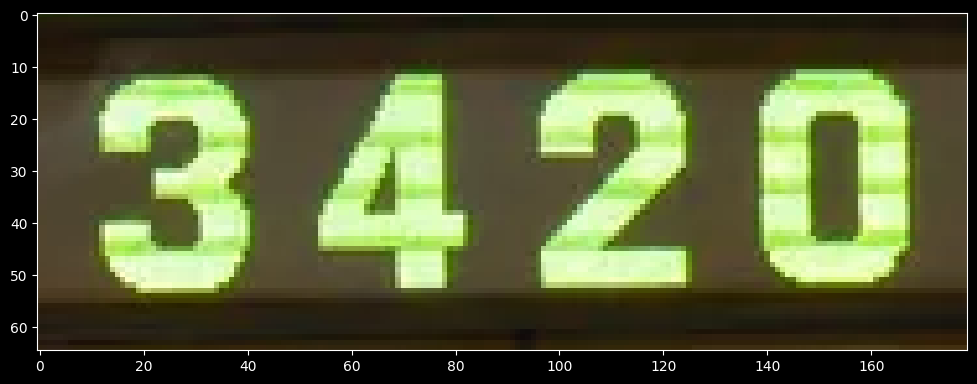

In [11]:
roi =  img_ori[box_y1-10:box_y2+10, box_x1-10:box_x2+10]
plt.figure(figsize=(12, 10))
plt.imshow(roi, cmap='gray')
plt.show()


In [12]:
text = pytesseract.image_to_string(roi, config='--psm 8')  # Use PSM 8 for single word/line of text
print("Recognized Text:", text)


Recognized Text: 3420

